# <a name='TOP'>Evaluate fungal genomic variant calling pipelines</a>

## Table of Content
* [Prepare analysis environment](#PREP)
* [VCF preprocessing and standardization](#VCF)
    * [Table S2: Total number of SNPs of each pipeline after each filtration step](#TS2)
* [Generating summary statistics from each callset](#SUM)
    * [Figure 1: Number of SNPs of each pipeline by clade](#F1)
    * [Figure S2: Missingness distribution of SNPs from each pipeline](#FS2)
* [Sensitivity and Specificity analysis of each pipeline](#SEN)
    * [Figure 2: Scatterplot of sensitivity and specificity of each pipeline](#F2)
* [Site level consensus analysis](#SITE)
    * [Figure 3: Comparison of SNPs called across pipelines](#F3)
    * [Figure 4: High confidence SNPs missed by each pipeline](#F4)
    * [Figure S3: Private SNPs show low mapping quality and read depth in ds7 and ds12](#FS3)
* [Sample level consensus analysis](#SHA)
    * [Figure 5: Sample level SNP concordance by clades](#F5)
    * [Figure S1: Percentage of private SNPs for each pipeline by clade](#FS1)
* [Similarities of SNPs discovered from controlled isolates](#SNP)
    * [Table 2: SNP calls from each pipeline for control isolate comparisons](#T2)
* [Comparison of SNPs discovered from 16B25 reference genome: Figure S4](#EVAL)
    * [Figure S4: Scatterplot of SNP number from B8441 vs. 16B25](#FS4)

Note: click each subtitle above will navigate you to the corresponding analysis codes, while click the title of each analysis session will bring you back to the top. 

## <a name='PREP'>[Prepare analysis environment](#TOP)</a> 
The analyses depend on following Python3 libraries, as well as those command line (CLI) tools :
```
    vcftools-v0.1.15
    zlib-1.2.11
    bcftools-v1.8
    htslib-v1.10.2 (bgzip and tabix)
```
Note that all the tables and plots can be reproduced without the above CLI tools. You could **only** need the CLI tools if you wanted to reproduce all the tables and plots from scratch (from the VCF files). To do that you need to uncomment the bash cells for corresponding analysis. 

In [1]:
import os
import sys
import subprocess as sp
from io import StringIO
from glob import glob

import pandas as pd
import math
import numpy as np
import statistics as stat
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import statistics as sta
import matplotlib.font_manager

from funpipe.vcf import siteinfo, gt_pair, vcf
from funpipe.utils import run


class snp_share:
    """ SNP counts in categories 
    
    To do: add missing categories in this module
    Description
    -----------
        Of all discovered SNPs for a paticular pipeline, which shared SNP category
        does it belongs to. It inputs a 
        
    Example
    -------
    >>> pipe_dos =  [0,  1, 0, 0, 1, 1, 1]
    >>> np_called = [9, 10, 8, 8, 7, 7, 6]   # number of pipelines called
    >>> pipe = snp_share(pipe_dos, np_called)
    
    >>> pipe.hit_cates
    >>> pipe.miss_cates
    
    """
    def __init__(self, var_series):
        var_series = var_series[var_series!=0]
        self.counts = var_series.value_counts()
        self.counts.index = self.counts.index.astype('int32')

        self.total = len(var_series)
        self.private = len(var_series[var_series==1])
        self.share = len(var_series[var_series>10])
        if self.total != 0:
            self.pct_private = round(self.private / self.total * 100, 2)
            self.pct_share = round(self.share / self.total * 100, 2)
        else:
            self.pct_private = np.nan
            self.pct_share = np.nan
    
    def plt(self, log=False):
        if log:
            lg_count_table = self.counts.apply(math.log)
            lg_count_table.sort_index().plot.bar()
        else:
            self.counts.sort_index().plot.bar()

            
callsets = [
    'ds01-cfsan',
    'ds02-gatk3',
    'ds03-gatk3',
    'ds04-gatk3',   
    'ds05-gatk3',
    'ds06-gatk3',
    'ds07-gatk4',
    'ds08-gatk4',
    'ds09-samtl',
    'ds10-samtl',
    'ds11-smtrm',
    'ds12-pilon'
]

samples = ['CA'+'{0:02d}'.format(i) for i in range(1,36)]

clades = pd.read_csv('data/sample_clades.tsv', sep='\t', header=0, index_col='Sample')

clade_map = {
    1 : 'South Asia',
    2 : 'East Asia',
    3 : 'Africa',
    4 : 'South America'
}

# font = {'family' : 'normal',
#         'size'   : 11}
# matplotlib.rc('font', **font)


## <a name='VCF'>[VCF preprocessing and standardization](#TOP)</a>
Including:
 - Standardize contig, sample names and sample orders in the VCF.
 - Diploid to haploid.
 - Mask heterogygote genotype calls.
 - Remove sites with asterisk marks (*) in the ALT field.
 - Remove INFO field and 'GT' FORMAT fields to reduce file size.

Note that there are heterozygous sites in some diploid call sets, such as `CA02` in `ds07` `scaffold00012-31812-T-A,G 1/2` `scaffold00012-31813-T-G,C 0/2` etc. 

In [2]:
%%bash
### VCF standardization ###
# The following script assumes availablility of high number of cores, recommond to run on a UGES machine.

set -euo pipefail

# vcfstats () {
#     # Get summary statistics for a set of VCFs
#     SUFFIX=$1  # VCF suffix

#     TOTAL=vcfstats/total_sites_${SUFFIX}.tsv
#     MNP=vcfstats/total_mnps_${SUFFIX}.tsv
#     MULTI=vcfstats/total_multi_sites_${SUFFIX}.tsv
#     SAMHAP=vcfstats/sites_per_sample_hap_${SUFFIX}.tsv
#     SAMDIP=vcfstats/sites_per_sample_dip_${SUFFIX}.tsv

#     echo "" > haptmp.tsv
#     echo "" > diptmp.tsv
#     echo "" > ${TOTAL}
#     echo "" > ${MNP}
#     echo "" > ${MULTI}
    
#     for STAT in vcfstats/*${SUFFIX}.stats; do

#         # total number of SNPs
#         grep '^SN' $STAT | awk -F '\t' 'NR==4 {print $4}' >> ${TOTAL}
#         # MNPs
#         grep '^SN' $STAT | awk -F '\t' 'NR==5 {print $4}' >> ${MNP}
#         # total number of multiallelic SNP sites
#         grep '^SN' $STAT | awk -F '\t' 'NR==9 {print $4}' >> ${MULTI}

#         # number of SNPs for each sample
#         paste haptmp.tsv <(grep '^PSC' $STAT | cut -f3,13 | sort | cut -f2) > ${SAMHAP}
#         paste diptmp.tsv <(grep '^PSC' $STAT | cut -f3,5,6 | sort | cut -f2,3 \
#             | perl -e 'while(<>){ chomp($_); $tot=0; foreach (split(/\t/, $_)) {$tot+=$_;} print $tot,"\n"}') > ${SAMDIP} 
#         cp ${SAMHAP} haptmp.tsv
#         cp ${SAMDIP} diptmp.tsv
#     done
#     rm *tmp.tsv
# }


# cd /gsap/garage-fungal/fungal-research-projects/data/benchmark/pipelines_comparison

echo "Generate sample maps for each call set"
# while IFS=$'\t' read -r -a entries; do 
#     # generate sample map
#     if ! [[ $(bcftools query -l ${entries[1]} | head -1) == CA* ]]; then
#         paste <(bcftools query -l ${entries[1]} | sort) samples.tsv | sed 's/\t/ /g' > ${entries[0]}.sample_map.tsv    
#     fi
#     # summary statistics
#     bcftools stats -s- ${entries[1]} > vcfstats/${entries[0]}.raw.stats &
# done < snp_vcf_list.tsv 
# vcfstats raw


echo "Remove monomorphic sites, standardize contig name, sample name and sample orders."
# while IFS=$'\t' read -r -a entries; do
#     if [[ -f ${entries[0]}.sample_map.tsv ]]; then
#         # rename samples
#         bcftools annotate --rename-chrs chr_maps.txt -x ^FORMAT/GT ${entries[1]} \
#           | bcftools reheader -s ${entries[0]}.sample_map.tsv \
#           | bcftools filter -e 'N_ALT==0 || TYPE!="SNP"' -O z > ${entries[0]}.snps.vcf.gz \
#         && bcftools stats -s- ${entries[0]}.snps.vcf.gz > vcfstats/${entries[0]}.snps.stats &
#     else
#         # reorder samples
#         bcftools annotate --rename-chrs chr_maps.txt -x ^FORMAT/GT ${entries[1]} \
#             | bcftools filter -e 'N_ALT==0 || TYPE!="SNP"' -O z > ${entries[0]}.tmp.vcf.gz \
#         && bcftools view -s $(echo "CA"{01..35} | sed "s/ /,/g") -O z ${entries[0]}.tmp.vcf.gz \
#              > ${entries[0]}.snps.vcf.gz \
#         && bcftools stats -s- ${entries[0]}.snps.vcf.gz > vcfstats/${entries[0]}.snps.stats \
#         && rm ${entries[0]}.tmp.vcf.gz &
#     fi
# done < snp_vcf_list.tsv
# vcfstats snps


echo "Remove heterozygous genotypes, change diploid to haploid"
# for i in {01..12}; do
#     VCF=dataset${i}.snps.vcf.gz
#     OUT=$(echo $VCF | sed 's/vcf/hap.vcf/g')
#     STATS=$(echo $OUT | sed 's/vcf.gz/stats/g')
#     bcftools filter -e 'GT="het"' $VCF \
#       | sed 's/\([0-9\.]\)\/[^\t]\+/\1/g' | bgzip > $OUT \
#     && bcftools stats -s- $OUT > vcfstats/$STATS &
# done
# vcfstats hap


echo "Remove sites with asterisk marks"
# for i in {01..12}; do
#     VCF=dataset${i}*hap.vcf.gz
#     OUT=$(echo $VCF | sed 's/vcf/no_star.vcf/g')
#     STATS=$(echo $OUT | sed 's/vcf.gz/stats/g')
#     zcat $VCF | grep -v '*' | bgzip > $OUT \
#     && bcftools stats -s- $OUT > vcfstats/$STATS &
# done
# vcfstats no_star

echo "Remove unused information"
# patch dataset09 header DPT4L not defined in header
# bcftools reheader -h dataset09.header.txt dataset09.snps.hap.no_star.vcf.gz > dataset09.patch_header.snps.hap.no_star.vcf.gz \
#     && tabix dataset09.patch_header.snps.hap.no_star.vcf.gz

# echo "Remove unused INFO and FORMAT fields"
# for file in dataset*.no_star.vcf.gz; do
#     OUT=$(echo $file | sed 's/vcf/mini.vcf/g')
#     STATS=$(echo $OUT | sed 's/vcf.gz/stats/g')
# #     bcftools annotate -x INFO,QUAL $file | bcftools reheader -h mini_header.txt | bgzip > $OUT
# #     tabix $OUT
#     bcftools stats -s- $OUT > vcfstats/$STATS
# done
# vcfstats mini

# echo "Remove unused Alt alleles"
# for i in {01..12}; do
#     VCF=dataset${i}*mini.vcf.gz
#     OUT=$(echo $VCF | sed 's/vcf/trim_alt.vcf/g')
#     STATS=$(echo $OUT | sed 's/vcf.gz/stats/g')
#     bcftools view --trim-alt-alleles $VCF | bcftools filter -e 'N_ALT==0 || TYPE!="SNP"' | bgzip > $OUT
#     bcftools stats -s- $OUT > vcfstats/$STATS
# done
# vcfstats trim_alt
#
# for file in *trim_alt.vcf.gz; do 
#     FREQ=$(echo $file | sed 's/.vcf.gz//g')
#     vcftools --gzvcf $file --freq2 --out vcfstats/$FREQ \
#     && cut -f4,5 vcfstats/${FREQ}.frq > vcfstats/${FREQ}.freq.tsv &
# done


Generate sample maps for each call set
Remove monomorphic sites, standardize contig name, sample name and sample orders.
Remove heterozygous genotypes, change diploid to haploid
Remove sites with asterisk marks
Remove unused information


### <a name='TS2'>[Table S2: Total number of sites for each call set](#TOP)</a>

In [3]:
nsnps = pd.read_csv('data/total_snps_summary.tsv', sep='\t', header=0, index_col='Total SNPs',
                    thousands=r',')
nsnps.columns = callsets
nmult = pd.read_csv('data/total_multialleles_summary.tsv', sep='\t', header=0, index_col='Multi-allelic sites',
                    thousands=r',')
nmult.columns = callsets
nsnps

,ds01-cfsan,ds02-gatk3,ds03-gatk3,ds04-gatk3,ds05-gatk3,ds06-gatk3,ds07-gatk4,ds08-gatk4,ds09-samtl,ds10-samtl,ds11-smtrm,ds12-pilon
Total SNPs,,,,,,,,,,,,
Initial,223736,228820,223268,222172,223322,223110,237277,224100,202854,231765,239476,228137
Remove monomorphic & MNPs & InDels,223736,228820,223268,222172,223322,223110,237277,224100,202854,231765,239476,228121
Remove het sites,223736,228820,223268,222172,223322,223110,224812,220197,202854,216782,230151,228121
Remove * sites,223736,228820,222361,222172,222415,222170,224812,220197,202854,216782,230151,228121
Minimize VCF,223736,228820,222361,222172,222415,222170,224812,220197,202854,216782,230151,228121
Remove unused ALT alleles,223736,228820,221724,222152,221790,222170,224812,220197,202854,216782,230151,228121


## <a name='SUM'>[Generating summary statistics from each callset](#TOP)</a>
* Calculating number of SNPs after standardization
* Missingness distributions
* **Calculate unique and shared SNPs within each pipeline**
    - Shared SNPs
    - Unique SNPs: include and exclude NAs
* **Pairwise comparison of call-set similarity amongst all pipelines**
    
* **General summary of call sets: MAF and missingness distributions**


### Summary of number of SNPs from each pipeline


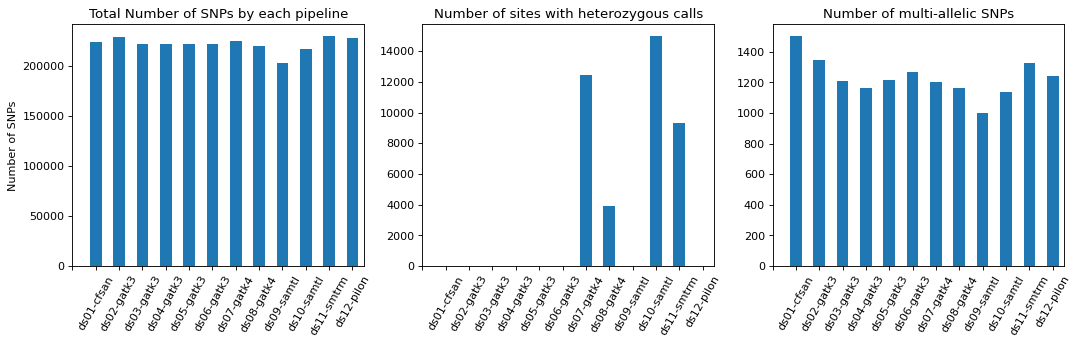

In [4]:
fig=plt.figure(figsize=(16,4), dpi=80, facecolor='w', edgecolor='k')

# Total number of SNPs by each pipeline
plt.subplot(1,3,1)
nsnps.iloc[-1].plot.bar()
plt.title('Total Number of SNPs by each pipeline')
plt.ylabel('Number of SNPs')
plt.xticks(range(-1,12), rotation=60)

# Number of sites with heterozygous calls
plt.subplot(1,3,2)
(nsnps.iloc[1] - nsnps.iloc[2]).plot.bar()
plt.title('Number of sites with heterozygous calls')
plt.xticks(range(-1,12), rotation=60)

# Number of multi-allelic SNPs
plt.subplot(1,3,3)
nmult.iloc[-1].plot.bar()
plt.title('Number of multi-allelic SNPs')
plt.xticks(range(-1,12), rotation=60)
plt.show()

###  <a name='FS2'> [Figure S2: Missingness distribution of SNPs from each pipeline](#TOP)</a>


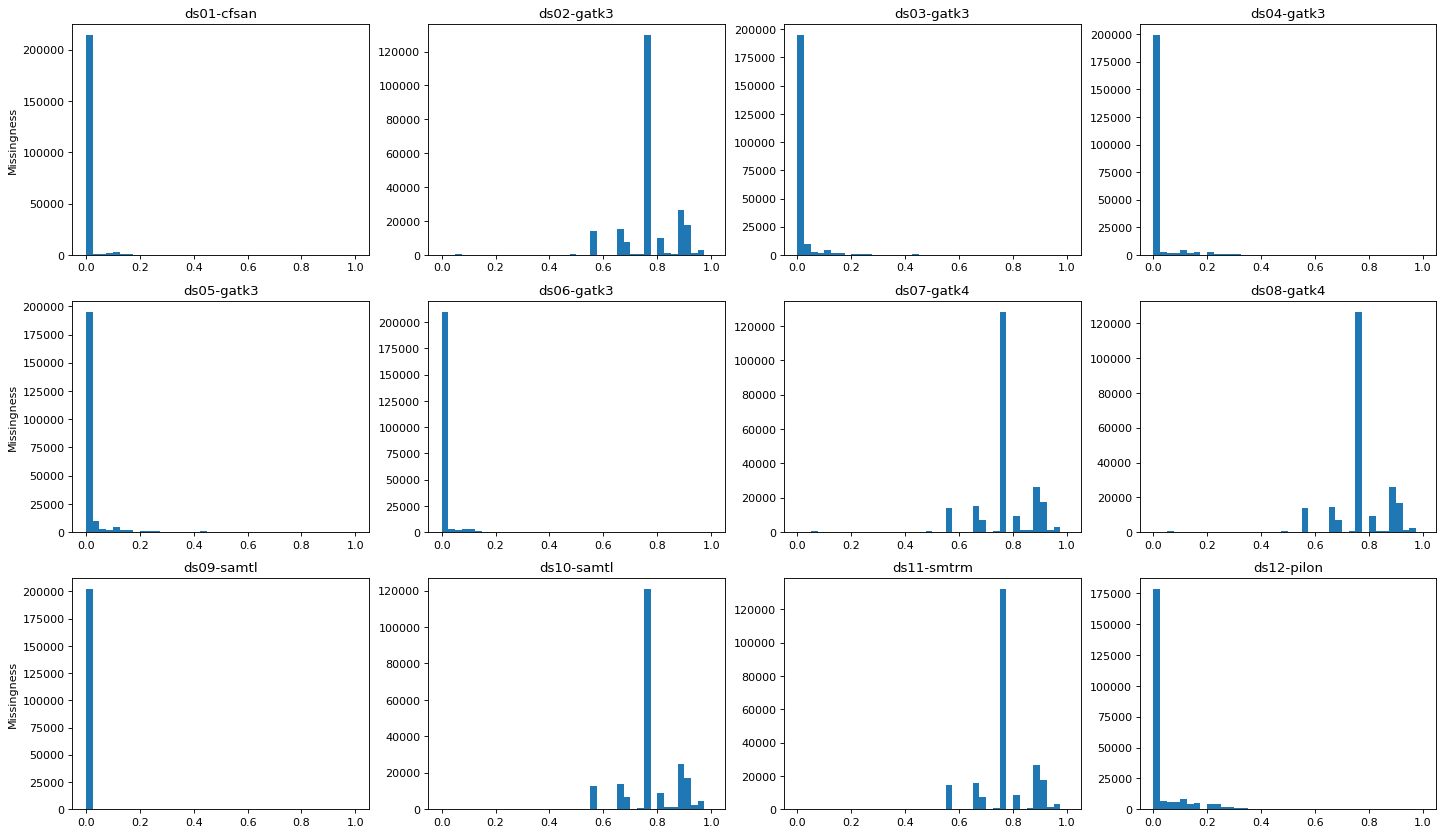

In [5]:
fig=plt.figure(figsize=(22, 13), dpi=80, facecolor='w', edgecolor='k')    

for i in range(1, 13):
    plt.subplot(3,4,i)
    ds = 'dataset{0:02d}'.format(i)
    af = pd.read_csv(glob('data/vcfstats/'+ds+'*trim_alt.freq.tsv.gz')[0], sep='\t', header=0, 
                     names=['N_CALL', 'Ref_AF'])
    af['F_MISS'] = (35 - af['N_CALL'])/35
    plt.hist(af['F_MISS'], bins=40, range=(0,1))
    plt.title(callsets[i-1])
    if i in [1,5,9]:
        plt.ylabel('Missingness')
fig.savefig('figs/FigureS2_miss_dist.pdf')

### <a name='F1'>[Figure 1: Plot number of SNPs for each clade](#TOP)</a>

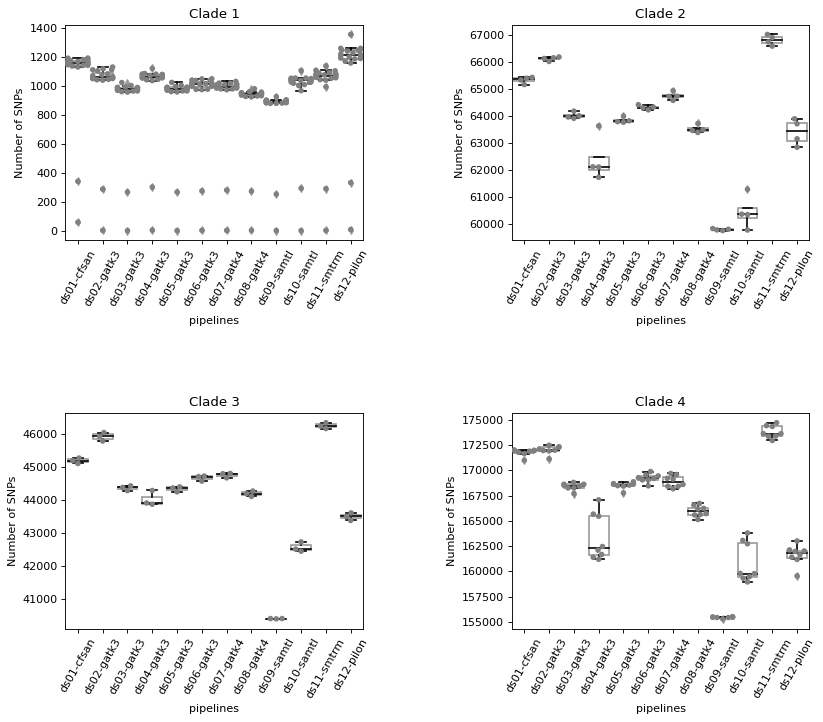

In [6]:
import warnings
warnings.filterwarnings("ignore")

# Reformat dataset
# read stats snp per each sample
snp_per_sample = pd.read_csv('data/vcfstats/sites_per_sample_hap_trim_alt.tsv.gz', 
                             sep='\t', usecols=range(1,13), header=None, names=callsets)
snp_per_sample.index = samples

# data frame with metadata 
nsnp_meta = pd.concat([snp_per_sample, clades], axis=1)

nsnp_meta_melt = nsnp_meta.melt(id_vars=['Clade'], value_name='nSNPs', var_name='pipelines')

# Generate the plot
fig = plt.figure(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='black')
plt.subplots_adjust(wspace=0.5, hspace=0.8)
for clade_i in range(1,5):
    clade_data = nsnp_meta_melt[nsnp_meta_melt['Clade']==clade_i]
    plt.subplot(2, 2, clade_i)
    ax = sns.swarmplot(data=clade_data, x='pipelines', y='nSNPs', color='grey')
    plt.title('Clade '+str(clade_i))
    plt.setp(ax.get_xticklabels(), rotation=60)
    
    # boxplot no fill
    ax = sns.boxplot(data=clade_data, x='pipelines', y='nSNPs', color='white')
    plt.setp(ax.artists, edgecolor = 'black', facecolor='w')
    plt.setp(ax.lines, color='black')
    plt.ylabel('Number of SNPs')

    
plt.show()
fig.savefig("figs/Figure1_n_snps_per_clade.pdf", bbox_inches='tight')


## <a name='SNP'>[Comparison of SNPs from same isolate, patient or outbreak (Table 2)](#TOP)</a>

Calculate shared and unique SNPs within each callset amongst 3 sample pairs: samples from same isolate, patient and outbreak.

- CA25 vs. CA26: same isolate
- CA28 vs. CA29: same patient
- CA08 vs. CA27: same outbreak

Note: the below analysis involved in computing from VCF files, which would take some time and compute resources. To reproduce the results, have the VCF files inplace and uncomment the below cell.

In [7]:
# def mat2df(mat, dt_int=True, prefix=None):
#     """ Transform numpy matrix to dataframe and add column and row information """
#     if dt_int:
#         df = pd.DataFrame(mat, dtype='int32')
#     else:
#         df = pd.DataFrame(mat)
#     df.columns = ['isolate', 'patient', 'outbreak']
#     df.index = callsets
#     if prefix is not None:
#         df.to_csv('data/'+prefix+'.tsv', sep='\t')
#     return df


# np.set_printoptions(suppress=True)

# share = np.zeros((12, 3))
# unique_w_na = np.zeros((12, 3))
# unique_wo_na = np.zeros((12, 3))

# pairs = ((24, 25), (27, 28), (7, 26))  # same isolate, same patient and same outbreak

# for i in range(1, 13):
#     name = '{0:02d}'.format(i)
#     file = glob('data/mvcfs/'+'*'+str(name)+'*trim_alt.vcf.gz')
#     fungal_vcf = vcf(file[0], prefix='dataset'+str(name)).cal_dos()
#     # compare 3 pairs
#     for j in range(0, 3):
#         share[i-1, j], unique_w_na[i-1, j] = fungal_vcf.samples_concord(pairs[j][0], pairs[j][1])
#         share[i-1, j], unique_wo_na[i-1, j] = fungal_vcf.samples_concord(pairs[j][0], pairs[j][1], na_ignore=True)

# share = mat2df(share, prefix='shared_snps')
# unique_na = mat2df(unique_w_na, prefix='unique_snps_w_na')
# unique_no = mat2df(unique_wo_na, prefix='unique_snps_wo_na')


### <a name='T2'> [Table 2: Comparison of SNPs from same isolate, patient or outbreak](#TOP)</a>

In [8]:
print("Shared SNPs")
share = pd.read_csv('data/shared_snps.tsv', sep='\t', header=0, index_col=0)
print(share)

print("\nUnique SNPs with NA")
unique_na = pd.read_csv('data/unique_snps_w_na.tsv', sep='\t', header=0, index_col=0)
print(unique_na)

print("\nUnique SNPs without NA")
unique_no = pd.read_csv('data/unique_snps_wo_na.tsv', sep='\t', header=0, index_col=0)
print(unique_no)

Shared SNPs
            isolate  patient  outbreak
ds01-cfsan     1135     1147      1142
ds02-gatk3     1020     1065      1027
ds03-gatk3      955      974       961
ds04-gatk3     1027     1053      1024
ds05-gatk3      956      977       961
ds06-gatk3      974     1010       980
ds07-gatk4      971     1000       990
ds08-gatk4      923      948       942
ds09-samtl      878      894       894
ds10-samtl      991     1031      1011
ds11-smtrm     1025     1073      1042
ds12-pilon     1146     1176      1182

Unique SNPs with NA
            isolate  patient  outbreak
ds01-cfsan       21       23        28
ds02-gatk3       61       90        49
ds03-gatk3        9       23        17
ds04-gatk3       63       51        50
ds05-gatk3        9       20        18
ds06-gatk3       39       53        41
ds07-gatk4        8       26         8
ds08-gatk4        3       10         5
ds09-samtl        0        3         2
ds10-samtl       27       38        21
ds11-smtrm       30       53   

## <a name="SHA">[Sample consensus analysis](#TOP)</a>

In [9]:
%%bash
### Per-sample consensus analysis ###
# cd data
# [ ! -d sample_comp ] && mkdir sample_comp

# cd sample_comp

# ## Per-sample consensus ##

# bcftools merge ../*trim_alt.vcf.gz --force-samples | bgzip > all.callsets.vcf.gz
# bcftools reheader -h all_merge_header.txt all.callsets.vcf.gz > all.callsets.patch_name.vcf.gz

# # calculate allele frequencies
# for i in {01..35}; do
#     bcftools view -s $(echo {1..12}:CA${i} | sed 's/ /,/g') all.callsets.patch_name.vcf.gz | \
#         bcftools filter -e 'AC==0' | bgzip > ca${i}.vcf.gz
#     vcftools --gzvcf ca${i}.vcf.gz --freq2 --out ca${i}
#     cut -f1-5 ca${i}.frq | grep -v 'nan' > ca${i}.af.tsv
# done


# ## Generate consensus VCF ##
# for i in {01..35}; do
#     # generate per-sample vcf include reference calls
#     bcftools view -s $(echo {1..12}:CA${i} | sed 's/ /,/g') all.callsets.patch_name.vcf.gz | \
#         bgzip > ca${i}.with_ref.vcf.gz 

#     # update consensus VCF header
#     cat consensus_header.txt > ca${i}.cons.final.vcf
#     sed -i "$ s/$/\tCA${i}/" ca${i}.cons.final.vcf

#     # filter VCFs
#     bcftools filter -i 'AN > 9 & (AC >9 | AC<3)' ca${i}.with_ref.vcf.gz | \
#         bcftools query -f '%CHROM %POS %REF %ALT %AN %AC %AC{0}\n' | \
#         awk '{if($7>9) {print $1"\t"$2"\t.\t"$3"\t"$4"\t.\t.\tAN="$5",AC="$6"\tGT\t1"} else {print $1"\t"$2"\t.\t"$3"\t"$4"\t.\t.\tAN="$5",AC="$6"\tGT\t1"}}' \
#         >> ca${i}.cons.final.vcf
#     bgzip -f ca${i}.cons.final.vcf
#     tabix -f ca${i}.cons.final.vcf.gz
# done

# # generate final vcf
# bcftools merge ca*.cons.final.vcf.gz | bgzip > cauris.consensus.vcf.gz \
#     && tabix cauris.consensus.vcf.gz

In [10]:
snp_counts = [0] * 35
for i in range(1, 36):
    sample = 'ca{0:02d}'.format(i)
    af = pd.read_csv('data/sample_comp/'+sample+'.af.tsv.gz', header=0, sep='\t', 
                     names=['ID', 'AC', 'N_ALLELES', 'N_CHR', 'AF'])
    af['MAJOR_FREQ'] = af['AF'].apply(lambda x: x if x > 0.5 else 1 - x)
    af['AC'] = (af['N_CHR']*af['MAJOR_FREQ']).astype('int')
    snp_counts[i-1] = af['AC'].value_counts().sort_index()
samp_share = pd.DataFrame(snp_counts).fillna(0)
samp_share.index = samples
samp_share = pd.concat([samp_share, clades], axis=1)

### <a name='F5'>[Figure 5: Sample level SNP concordance by clades](#TOP)</a>

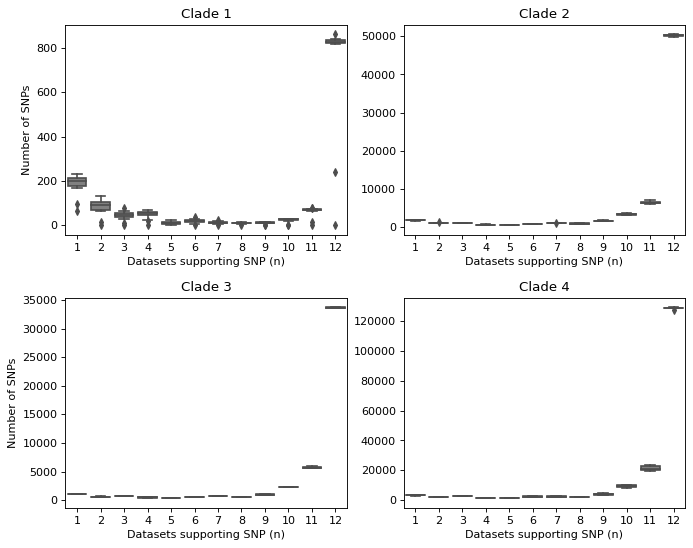

In [11]:
fig=plt.figure(figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')    
plt.subplots_adjust(hspace=0.3)

for i in range(1,5):
    plt.subplot(2,2,i)
    sns.boxplot(data = samp_share.loc[samp_share.Clade==i, [x for x in range(1,13)]], color='grey')
    plt.title('Clade '+str(i))
    plt.xlabel('Datasets supporting SNP (n)')

    if i in [1,3]:
        plt.ylabel('Number of SNPs')
plt.show()
fig.savefig('figs/Figure5_sample_consensus.pdf')

### <a name='SOU'>[Source of private SNPs from each pipeline in each clade](#TOP)</a>

Get source of private SNPs (shared snps == 1) in each clade1 sample, and summarize in a boxplot. 


In [12]:
### calculate percentage of private SNPs for each sample ###

# # for each clade, sample x pipeline count matrix
# ct_mat = [np.zeros((len(clades[clades.Clade==clade_i].index), 12)) for clade_i in range(1,5)]
# ct = [0] * 4

# for clade_i in range(1,5):
#     cl = clades[clades.Clade==clade_i].index
#     n_samples = len(cl)
#     # for each sample, calculate number of private SNP from each pipeline
#     for smp_i in range(0, n_samples):
#         dosmat = vcf('data/sample_comp/'+cl[smp_i].lower()+'.vcf.gz').cal_dos()._dosage_matrix.fillna(0)
#         for call_i in range(0,12):
#             # number of SNP called in each site
#             n_called = dosmat.apply(sum, axis=1)   
#             # percentage of private SNPs for each 
#             ct_mat[clade_i-1][smp_i, call_i] = snp_share(n_called * dosmat[call_i]).pct_private
#     # matrix to dataframe 
#     ct[clade_i-1] = pd.DataFrame(ct_mat[clade_i-1]).fillna(0)
#     ct[clade_i-1].columns = callsets
#     ct[clade_i-1].index = cl
#     # output dataframe
#     ct[clade_i-1].to_csv('data/sample_comp/clade'+str(clade_i)+'.pct_private.tsv', sep='\t')
 

### <a name='FS1'>[Figure S1: Percentage of private SNPs for each pipeline by clades](#TOP)</a>

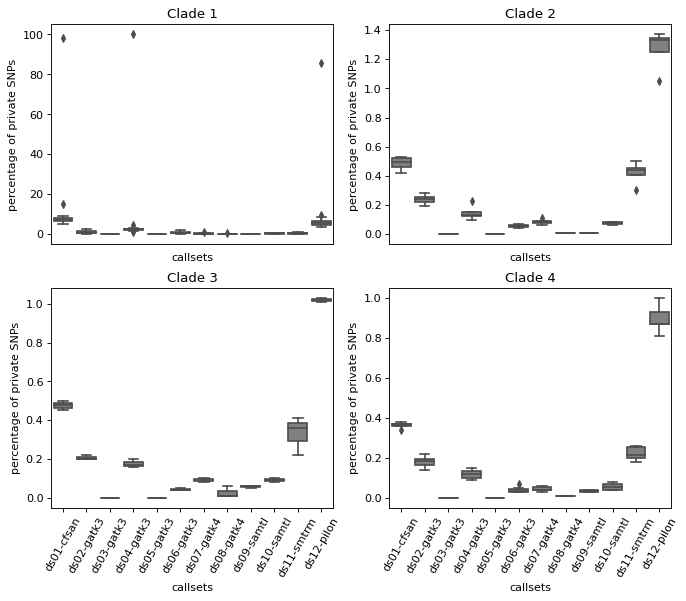

In [13]:
### Source of private SNPs for each clade ###
fig=plt.figure(figsize=(10, 8), dpi=80, facecolor='w', edgecolor='black')    
for clade_i in range(1,5):
    ct = pd.read_csv('data/sample_comp/clade'+str(clade_i)+'.pct_private.tsv', sep='\t', header=0, index_col=0)
    plt.subplot(2,2,clade_i)
    sns.boxplot(data = ct.melt(value_name='percentage of private SNPs', var_name='callsets'), 
                y='percentage of private SNPs', x='callsets', color='grey')
    plt.title('Clade '+str(clade_i))
    if clade_i in [1,2]:
        plt.xticks([])
    else:
        plt.xticks(rotation=60)
plt.show()
fig.savefig('figs/FigureS1.pdf')

## <a name='SITE'>[Site Consensus Analysis](#TOP)</a>

In [14]:
%%bash
### Data preprocessing ###
# for VCF in data/mvcfs/*trim_alt.vcf.gz; do
#     OUT=$(echo $VCF | sed 's/vcf.gz/sites.tsv/g')
#     bcftools query -f '%CHROM:%POS:%REF:%ALT\n' $VCF > $OUT
# done

In [15]:
### get var ids ###
# os.chdir('data/mvcfs')
# for i in range(1, 13):
#     name = '{0:02d}'.format(i)
#     with open(glob('dataset'+name+'*trim_alt.sites.tsv')[0]) as fh, open('data'+name+'.varid.tsv', 'w') as ofh:
#         ofh.write("varid\tds"+name+'\n')
#         for line in fh:
#             chr, pos, ref, alt = line.strip().split(':')
#             alts = alt.split(',')
#             for i in alts:
#                 if i != '*':
#                     ofh.write('-'.join([chr, pos, ref, i])+'\t1\n')

# # merge variant ID tables
# varf = sorted(glob('data*.varid.tsv'))
# allvar = pd.read_csv(varf[0], sep='\t',header=0)
# for i in range(1, 12):
#     allvar = allvar.merge(pd.read_csv(varf[i], sep='\t', header=0), how='outer')
# allvar = allvar.fillna(0)
# allvar = allvar.set_index('varid')
# allvar['n_called'] = allvar.sum(axis=1)
# allvar.to_csv('all_variant.tsv.gz', sep='\t', compression='gzip', )
# os.chdir('../..')

In [16]:
### Bar plot of SNP sharing across the samples ###

# count table
snpmetr = pd.read_csv('data/mvcfs/all_variant.tsv.gz', sep='\t', header=0, index_col='varid', 
                      names=['varid']+ callsets + ['n_called'])

count_table = snpmetr['n_called'].value_counts().sort_index()
count_table.index = count_table.index.astype('int32')

# count table for each callset
counts = [0] * 12
for idx in range(0,12):
    var_series = snpmetr['n_called'] * snpmetr[callsets[idx]]
    counts[idx] = snp_share(var_series)
    

In [17]:
### percentage of common SNPs ###
pct_cate = count_table.sort_index()/snpmetr.shape[0] * 100
pct_cate[9:].sum()

87.27233507393132

### <a name='F3'>[Figure 3: Comparison of SNPs called across pipelines](#TOP)</a>

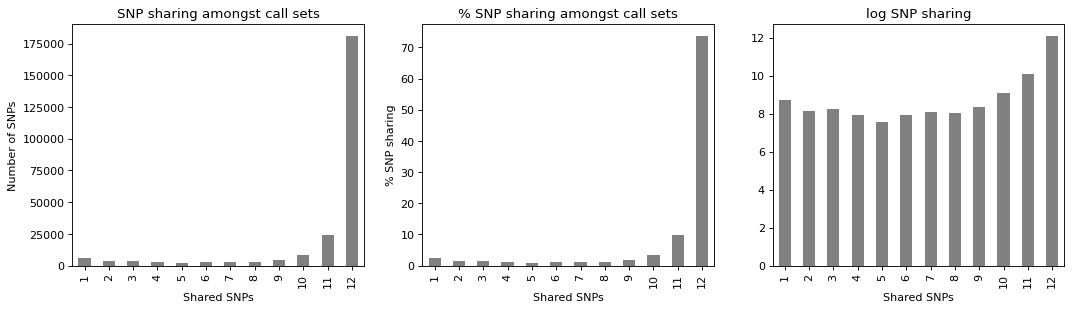

In [18]:
### plot log counts for each SNP category ###
lg_count_table = count_table.apply(math.log).sort_index()
lg_count_table

fig=plt.figure(figsize=(16, 4), dpi=80, facecolor='w', edgecolor='k')

# SNP sharing amongst call sets
plt.subplot(1,3,1)
count_table.sort_index().plot.bar(color='grey')
plt.title('SNP sharing amongst call sets')
plt.xlabel('Shared SNPs')
plt.ylabel('Number of SNPs')

# percentage
plt.subplot(1,3,2)
(count_table.sort_index()/snpmetr.shape[0] * 100).plot.bar(color='grey')
plt.title('% SNP sharing amongst call sets')
plt.ylabel('% SNP sharing')
plt.xlabel('Shared SNPs')

# 
plt.subplot(1,3,3)
lg_count_table.sort_index().plot.bar(color='grey')
plt.title('log SNP sharing')
plt.xlabel('Shared SNPs')

plt.show()
fig.savefig('figs/Figure3_site_consensus.pdf')

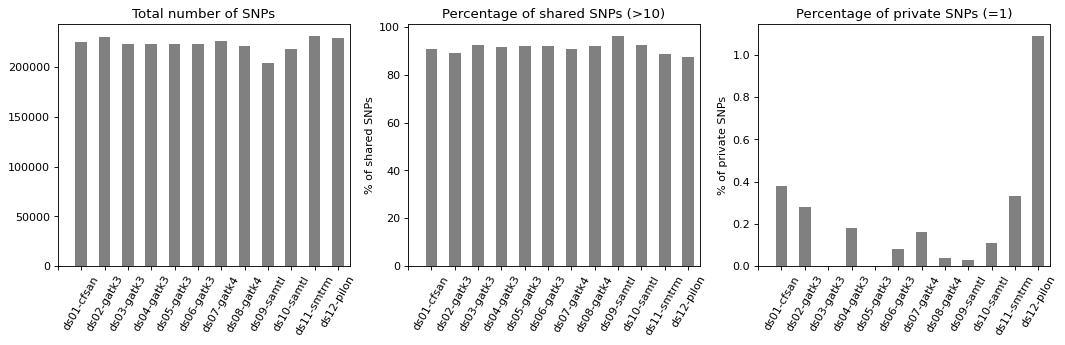

In [19]:
fig=plt.figure(figsize=(16, 4), dpi=80, facecolor='w', edgecolor='k')

pct = {
    'callset': callsets,
    'pct_share': [],
    'pct_private': [],
    'total': []
}

for idx in range(1,13):
    pct['pct_share'].append(counts[idx-1].pct_share)
    pct['pct_private'].append(counts[idx-1].pct_private)
    pct['total'].append(counts[idx-1].total)

pct = pd.DataFrame(pct)
pct.index=callsets

plt.subplot(1,3,1)
pct.total.plot.bar(color='grey')
plt.title('Total number of SNPs')
plt.xticks(range(-1,12), rotation=60)

plt.subplot(1,3,2)
pct.pct_share.plot.bar(color='grey')
plt.title('Percentage of shared SNPs (>10)')
plt.xticks(range(-1,12), rotation=60)
plt.ylabel('% of shared SNPs')

plt.subplot(1,3,3)
pct.pct_private.plot.bar(color='grey')
plt.title('Percentage of private SNPs (=1)')
plt.xticks(range(-1,12), rotation=60)
plt.ylabel('% of private SNPs')
plt.show()

fig.savefig('figs/Figure3_site_private_snps.pdf')

### <a name='F4'>[Figure 4: High confidence SNPs missed by each pipeline](#TOP)</a>

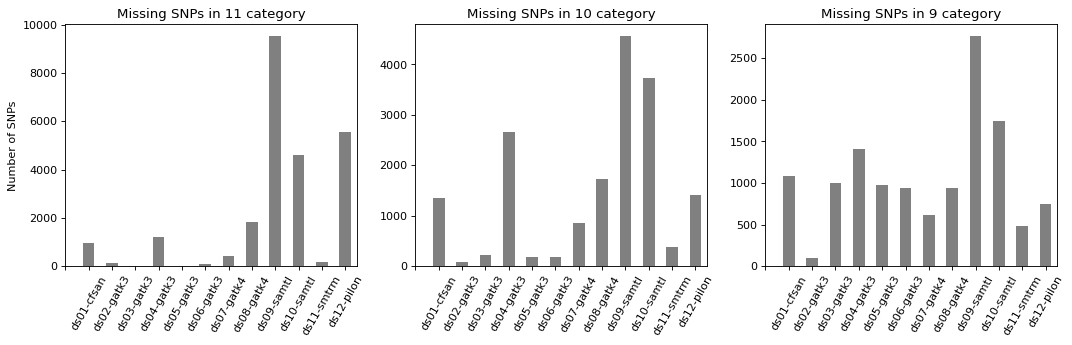

In [20]:
def miss_source(snpmetr, n_share):
    miss = abs(snpmetr[snpmetr['n_called'] == n_share] - 1)
    return miss.iloc[:, range(0,12)].sum(axis=0)

snpmetr = pd.read_csv('data/mvcfs/all_variant.tsv.gz', sep='\t', header=0, index_col='varid', 
                      names=['varid']+ callsets + ['n_called'])

fig=plt.figure(figsize=(16, 4), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(1,3,1)
miss_source(snpmetr, 11).plot.bar(color='grey')
plt.ylabel('Number of SNPs')
plt.title('Missing SNPs in 11 category')
plt.xticks(range(-1,12), rotation=60)


plt.subplot(1,3,2)
miss_source(snpmetr, 10).plot.bar(color='grey')
plt.title('Missing SNPs in 10 category')
plt.xticks(range(-1,12), rotation=60)

plt.subplot(1,3,3)
miss_source(snpmetr, 9).plot.bar(color='grey')
plt.title('Missing SNPs in 9 category')
plt.xticks(range(-1,12), rotation=60)

plt.show()
fig.savefig('figs/Figure4_site_miss_common_snps.pdf')

## <a name='ACC'>Access quality of unique SNPs discovered only by a single pipeline</a>
Use dataset07 as an example, to show if distribution of DP, MQ, FS and QD change with the SNP sharing. 

[[to top](#TOP)]

In [21]:
%%bash
### Extract info from vcf of dataset07 ###
# printf "varid\tMQ\tQD\tDP\tFS\n" > data/private_snps/dataset07.info.tsv
# bcftools query -f '%CHROM-%POS-%REF-%ALT\t%INFO/MQ\t%INFO/QD\t%INFO/DP\t%INFO/FS\n' data/dataset07.*.vcf.gz |
# perl -e '
# while(<>){
#     if(/,/) {
#         @fields=split(/\t/, $_); 
#         ($chr, $pos, $ref, $alts) = split(/-/, $fields[0]); 
#         @alts = split(/,/, $alts); 
#         foreach $alt (@alts) {
#             print join("\t", "$chr-$pos-$ref-$alt", $fields[1], $fields[2], $fields[3], $fields[4]),"\n";
#         }
#     } else { print $_; }
# }' >> data/private_snps/dataset07.info.tsv
# gzip dataset07.info.tsv.gz

### <a name='FS3'>[Figure S3: Private SNPs show low mapping quality and read depth in ds7 and ds12](#TOP)</a>

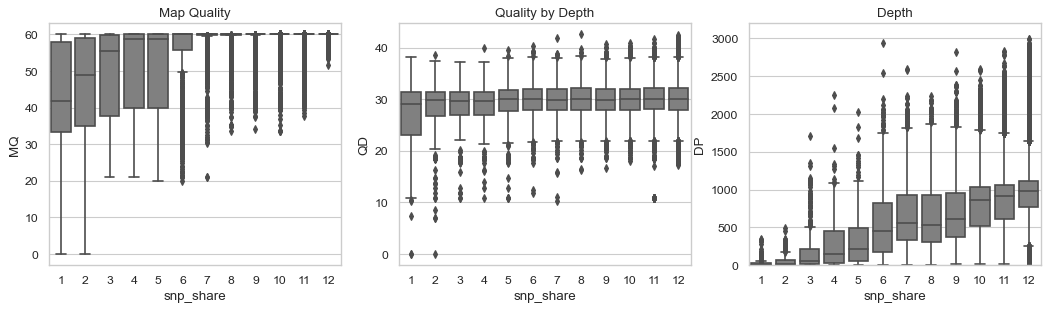

In [22]:
### Generate barplot of MQ, DP, QD, FS ###
snpmetr = pd.read_csv('data/mvcfs/all_variant.tsv.gz', sep='\t', header=0, index_col='varid', 
                      names=['varid']+ callsets + ['n_called'])
qual = pd.read_csv('data/private_snps/dataset07.info.tsv.gz', sep='\t', header=0, index_col='varid', 
                   dtype={'MQ': np.float32, 'QD': np.float32, 'DP': np.float32, 'FS': np.float32}, 
                   na_values='.').fillna(0)

# MQ, QD, DP, FS
var_series = snpmetr['n_called'] * snpmetr['ds07-gatk4']
var_series = var_series[var_series !=0]
var_ct = var_series.to_frame()
var_ct.columns = ['counts']
var_ct = var_ct.astype({'counts': np.int32})

ds7 = qual.merge(var_ct, left_index=True, right_index=True)
ds7.columns = ['MQ', 'QD', 'DP', 'FS', 'snp_share']


fig=plt.figure(figsize=(16, 4), dpi=80, facecolor='w', edgecolor='k')

sns.set(style="whitegrid")
plt.subplot(1,3,1)
ax = sns.boxplot(x='snp_share', y='MQ', data=ds7, color='grey')
plt.title('Map Quality')

plt.subplot(1,3,2)
sns.set(style="whitegrid")
ax = sns.boxplot(x='snp_share', y='QD', data=ds7, color='grey')
plt.title('Quality by Depth')

plt.subplot(1,3,3)
sns.set(style="whitegrid")
ax = sns.boxplot(x='snp_share', y='DP', data=ds7[ds7.DP < 3000], color='grey')
plt.ylim(0,3200)
plt.title('Depth')

plt.show()

fig.savefig('figs/FigureS3_1.pdf')

## <a name='PIL'>[Private SNPs from dataset 12](#TOP)</a>

In [23]:
%%bash
### Extract info from vcf of dataset12 (pilon) ###
# cd data/private_snps

# printf "varid\tMQ\tQD\tDP\n" > dataset12.info.tsv
# bcftools query -f '%CHROM-%POS-%REF-%ALT\t%INFO/MQ\t%INFO/QD\t%INFO/DP\n' ..mvcfs/dataset12.*.no_star.vcf.gz |
# perl -e '
# while(<>){
#     if(/,/) {
#         chomp;
#         @fields=split(/\t/, $_); 
#         ($chr, $pos, $ref, $alts) = split(/-/, $fields[0]); 
#         @alts = split(/,/, $alts); 
#         foreach $alt (@alts) {
#             print join("\t", "$chr-$pos-$ref-$alt", $fields[1], $fields[2], $fields[3]),"\n";
#         }
#     } else { print $_; }
# }' >> dataset12.info.tsv

In [24]:
### quality scores of Sites in dataset 12 ###
qual = pd.read_csv('data/private_snps/dataset12.info.tsv.gz', sep='\t', header=0, index_col='varid', 
                   dtype={'MQ': np.float32, 'QD': np.float32, 'DP': np.float32, 'FS': np.float32}, 
                   na_values='.').fillna(0)
snpmetr = pd.read_csv('data/mvcfs/all_variant.tsv.gz', sep='\t', header=0, index_col='varid', 
                      names=['varid']+ callsets + ['n_called'])

# MQ, QD, DP
var_series = snpmetr['n_called'] * snpmetr['ds12-pilon']
var_series = var_series[var_series !=0]
var_ct = var_series.to_frame()
var_ct.columns = ['counts']
var_ct = var_ct.astype({'counts': np.int32})

ds = qual.merge(var_ct, left_index=True, right_index=True)
ds.columns = ['MQ', 'QD', 'DP', 'snp_share']
ds_priv = ds[ds.snp_share==1]

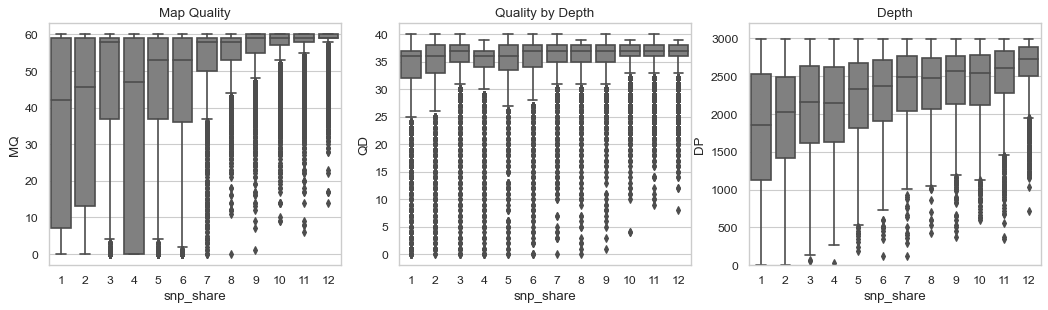

In [25]:
### Generate barplot of MQ, DP, QD ###
fig=plt.figure(figsize=(16, 4), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(1,3,1)
sns.set(style="whitegrid")
ax = sns.boxplot(x='snp_share', y='MQ', data=ds, color='grey')
plt.title('Map Quality')

plt.subplot(1,3,2)
sns.set(style="whitegrid")
ax = sns.boxplot(x='snp_share', y='QD', data=ds, color='grey')
plt.title('Quality by Depth')

plt.subplot(1,3,3)
sns.set(style="whitegrid")
ax = sns.boxplot(x='snp_share', y='DP', data=ds[ds.DP < 3000], color='grey')
plt.ylim(0,3200)
plt.title('Depth')

plt.show()
fig.savefig('figs/FigureS3_2.pdf')

## <a name='EVAL'>[Comparison of SNPs discovered from 16B25 reference genome](#TOP)</a>
Regenerate variant call set aligning to *Candida auris* 16B25 nanopore assembly.

In [26]:
%%bash
### Run variant calling and generate summary statistics ###
# cd /gsap/cdcfungal/WGS_pipelines/onprem_calls_16b25

# uncomment the following code chuck to re-run variant calling
# # on-prem variant calling
# run_gatk.sh gatk_cauris_onprem.json
# id: f7aa662b-0dee-4ff3-aefc-b60dfc3d7502

# # preprocess snp vcf
# grep -v '*' filtered_SNPs.vcf | bgzip > cauris_16b25_snps_nostar.vcf.gz \
# && tabix cauris_16b25_snps_nostar.vcf.gz

# bcftools stats -s- cauris_16b25_snps_nostar.vcf.gz > cauris_16b25_no_star.stats

# # Extract sites with all alt calls
# bcftools filter -i 'MAF==0' cauris_16b25_snps_nostar.vcf.gz | bgzip > cauris_16b25_snps_nostar_maf0.vcf.gz

Calculate Number of SNPs for each sample from reference genome (B8441 vs. 16B25)

In [27]:
def per_sample_snps(file, prefix):
    stats = (sp.check_output('grep \'^PSC\' ' + file + '| cut -f3,13', 
                            shell=True).decode())
    return pd.read_csv(StringIO(stats), sep='\t', header=None, names=['sample', prefix], 
                      index_col='sample')

c_16b25 = per_sample_snps('data/refdiff/cauris_16b25_no_star.stats', '16b25')
c_b8441 = per_sample_snps('data/refdiff/dataset03.snps.hap.no_star.stats',
                          'b8441')
data = pd.concat([c_16b25, c_b8441, clades], sort=False, axis=1)

# Calculate difference and percentage of differences within each clade
data['diff'] = data['16b25'] - data['b8441']
b8441_mean = []
for clade_i in range(1,5):
     b8441_mean.append(sta.mean(data[data.Clade==clade_i]['b8441']))

data['mean'] = data['Clade'].apply(lambda x: round(b8441_mean[x-1], 0))
data['pct_diff'] = round(data['diff'] / data['mean'] * 100, 0)

data.to_csv('data/refdiff/n_snps_16b25_vs_b8441.tsv', sep='\t')

### <a name='FS4'>[Figure S4: Scatterplots of number of SNPs in b8441 vs. 16b25](#TOP)</a>

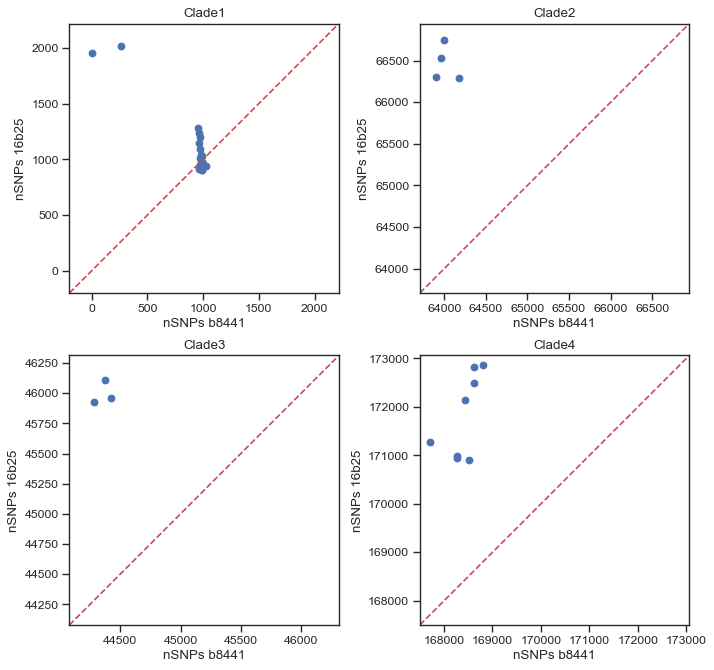

In [28]:
data = pd.read_csv('data/refdiff/n_snps_16b25_vs_b8441.tsv', sep='\t', header=0)

fig=plt.figure(figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
plt.subplots_adjust(wspace=0.3, hspace=0.22)

sns.set_style("ticks")
for clade_i in range(1,5):
    plt.subplot(2, 2, clade_i)
    plt.gca().set_aspect('equal', adjustable='box')
    subdata = data[data.Clade==clade_i][['b8441', '16b25']]
    plt.scatter(subdata['b8441'], subdata['16b25'])
    plt.xlabel('nSNPs b8441')
    plt.ylabel('nSNPs 16b25')
    plt.title('Clade'+str(clade_i))

    lim_min = min(subdata.min())-200
    lim_max = max(subdata.max())+200
    plt.xlim(lim_min, lim_max)
    plt.ylim(lim_min, lim_max)
    x=np.linspace(lim_min, lim_max,101) 
    plt.plot(x,x,'r--')
fig.savefig('figs/FigureS4_1.pdf')

### Plot distribution of SNP number differences between reference genomes

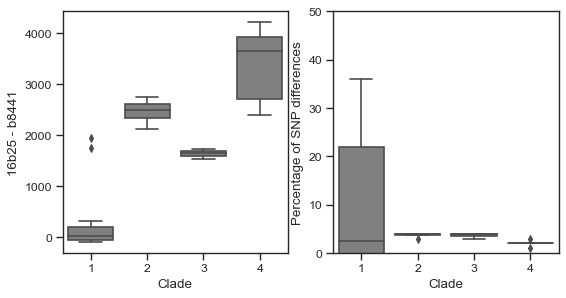

In [29]:
data = pd.read_csv('data/refdiff/n_snps_16b25_vs_b8441.tsv', sep='\t', header=0)

fig=plt.figure(figsize=(8, 4), dpi=80, facecolor='w', edgecolor='k')
sns.set_style("ticks")
plt.subplot(1,2,1)     
sns.boxplot(x='Clade', y='diff', data=data, color='grey')
plt.ylabel('16b25 - b8441')

plt.subplot(1,2,2)
sns.boxplot(x='Clade', y='pct_diff', data=data, color='grey')
plt.ylim(0,50)
plt.ylabel('Percentage of SNP differences')
plt.show()

fig.savefig('figs/FigureS4_2.pdf')

## <a name='SEN'>[Evaluation of sensitivity and specificity of each pipeline](#TOP)</a>
Using SNPs from CA05 and CA06 assemblies for this analysis

In [30]:
def plot_with_labels(coord, labels, main, minx, miny):
    assert len(coord) == len(labels), 'coord len is not equal to labels len'
    for i, label in enumerate(labels): #get (0, label)
        x, y = coord[i] #2 dim
        plt.scatter(x, y, color='grey')
        plt.title(main)
        plt.annotate(label,
                xy=(x, y), #show point 
                xytext=(5, 2), #show annotate
                textcoords='offset points',
                ha='right',
                va='bottom')
    plt.xlabel('Specificity')
    plt.ylabel('Sensitivity')
    plt.xlim(min_x * 0.998, 1)
    plt.ylim(min_y * 0.998, 1)


Calculate Calculate Precision, recall and F1 score from GATK's VariantEval output tsv file.

In [31]:
def conf_mat_cal(eval_df):
    """ Calculate Precision, recall and F1 score from a confusion matrix """
    eval_df['TP'] = eval_df['HOM_VAR_HOM_VAR']
    eval_df['FP'] = eval_df['HOM_VAR_UNAVAILABLE'] + eval_df['Mismatching_Alleles']
    eval_df['TN'] = eval_df['NO_CALL_UNAVAILABLE'] + eval_df['HOM_REF_UNAVAILABLE']
    eval_df['FN'] = eval_df['NO_CALL_HOM_VAR'] + eval_df['HOM_REF_HOM_VAR'] + eval_df['UNAVAILABLE_HOM_VAR']

    eval_df['spec'] = eval_df['TN']/ (eval_df['TN'] + eval_df['FP'])
    eval_df['recall'] = eval_df['TP'] / (eval_df['TP']+eval_df['FN'])   # recall = sensitivity
    eval_df['precision'] = eval_df['TP'] / (eval_df['TP']+eval_df['FP'])
    eval_df['f1'] = 2 * (eval_df['recall'] * eval_df['precision']/(eval_df['recall'] + eval_df['precision']))
    eval_df['harm'] = 2 * (eval_df['spec'] * eval_df['recall']/ (eval_df['spec']+eval_df['recall']))
    return eval_df

refs = ['CA05', 'CA06']
params = ['recall',  'spec', 'precision', 'f1', 'harm']

for param in params:
    p_out = pd.DataFrame(index = callsets)

    for ref in refs:
        eval_df = pd.read_csv('data/'+ref+'_var_eval.tsv', sep='\t', header=0)
        conf_df = conf_mat_cal(eval_df)
        p_out[ref] = conf_df[param].values
    p_out.to_csv('data/'+param+'.tsv', sep='\t')


### <a name='F2'>[Figure 2: Scatterplot of sensitivity and specificity of each pipeline](#TOP)</a>

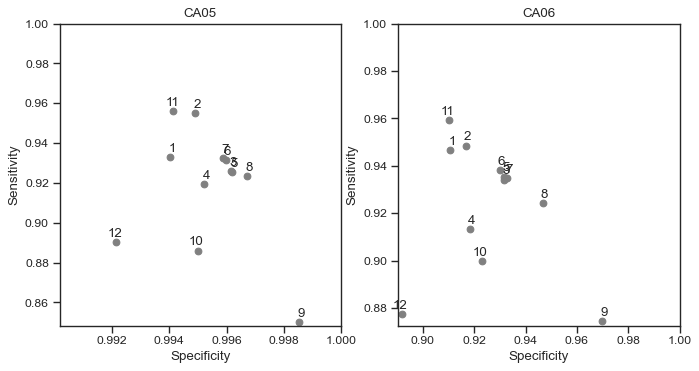

In [32]:
sens = pd.read_csv('data/recall.tsv', sep='\t', header=0)  # recall = sensitivity
spec = pd.read_csv('data/spec.tsv', sep='\t', header=0)

refs = ['CA05', 'CA06']

# ca05 plot
fig = plt.figure(figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')

for ri in range(2):
    plt.subplot(1, 2, ri+1)
    min_x = min(spec[refs[ri]])
    min_y = min(sens[refs[ri]])
    coord = [ (spec[refs[ri]][i], sens[refs[ri]][i]) for i in range(12) ]
    labels = [str(i) for i in range(1,13)]
    plot_with_labels(coord, labels, refs[ri], min_x, min_y)
fig.savefig('figs/Figure2_1.pdf')

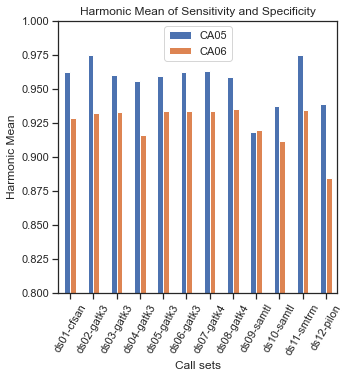

In [33]:
harm = pd.read_csv('data/harm.tsv', sep='\t', header=0, index_col=0)

harm.plot.bar(figsize=(5, 5))
plt.title('Harmonic Mean of Sensitivity and Specificity')
plt.ylabel('Harmonic Mean')
plt.xlabel('Call sets')
plt.ylim(0.8, 1)
plt.xticks(rotation=60)
plt.savefig('figs/Figure2_2.pdf')